In [1]:
import torch

In [2]:
torch.__version__

'2.3.0'

In [4]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
x = torch.rand(5, 3).to(device)

In [6]:
x

tensor([[0.0705, 0.6361, 0.7285],
        [0.8116, 0.3234, 0.1620],
        [0.7079, 0.6172, 0.8027],
        [0.2448, 0.2414, 0.0877],
        [0.2007, 0.3954, 0.0904]], device='cuda:0')

# K-Means

In [7]:
import matplotlib.pyplot as plt

In [8]:
N = 100
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])

In [9]:
X = torch.cat([x1, x2, x3], dim=0)
print(X.shape)

torch.Size([300, 2])


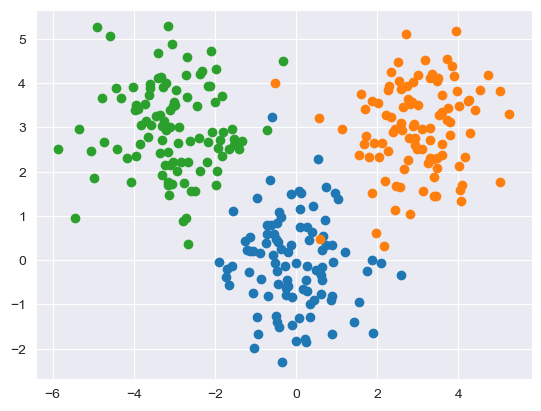

In [10]:
for i in range(3):
    plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
plt.show()

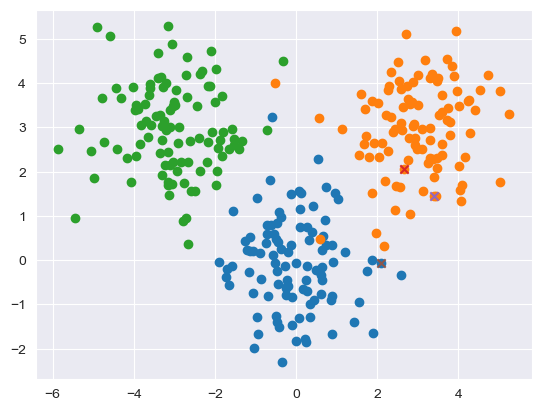

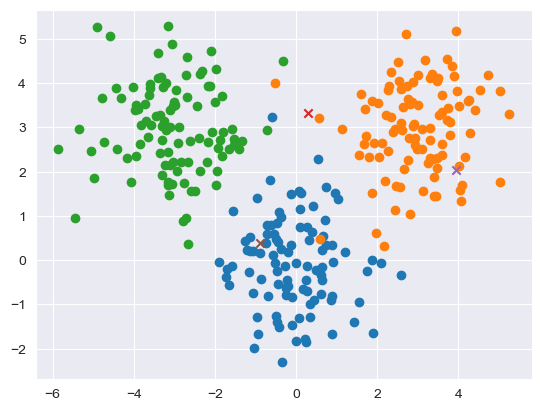

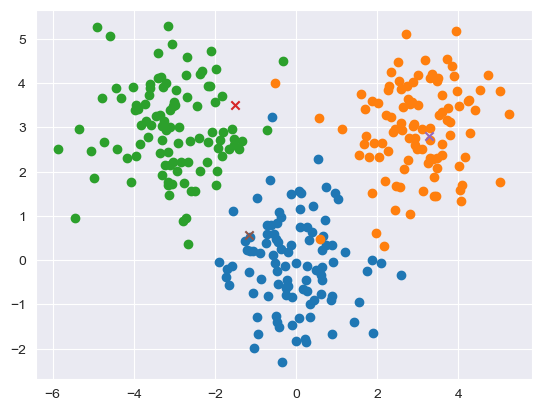

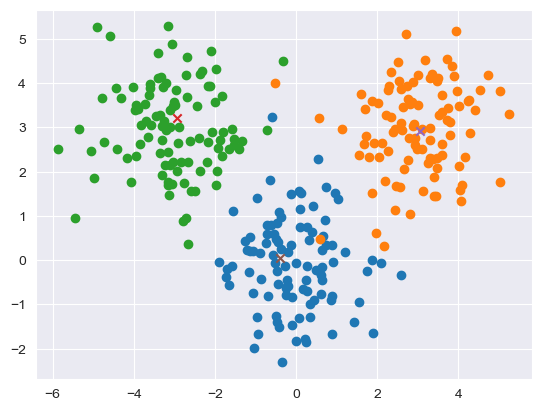

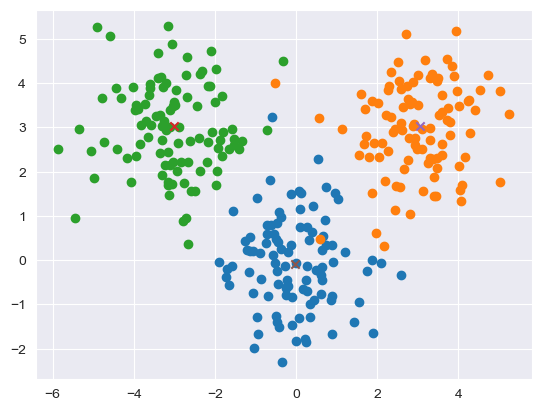

In [11]:
K = 3
centroids = X[torch.randperm(len(X))[:K]]
while True:
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for i in range(3):
        plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
    old_centroids = centroids.clone()
    for k in range(K):
        plt.scatter(centroids[k, 0], centroids[k, 1], marker='x')
        centroids[k] = X[clusters == k].mean(dim=0)
    change = torch.sum((centroids - old_centroids) ** 2)
    if change < 0.1:
        break
    plt.show()

In [12]:
import time
device = 'cuda'

N = 100000
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])
X = torch.cat([x1, x2, x3], dim=0).to(device)

t1 = time.time()
K = 3
centroids = X[torch.randperm(len(X))[:K]]
for _ in range(100):
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for k in range(K):
        centroids[k] = X[clusters == k].mean(dim=0)
print(time.time() - t1)

1.5435264110565186


# Auto differentiation

In [13]:
x = torch.tensor(3., requires_grad=True)
y = x**2 + 2*x + 1 
# y' = 2x + 2
y.backward()

In [14]:
x.grad # 2(3) + 2

tensor(8.)

# Regression

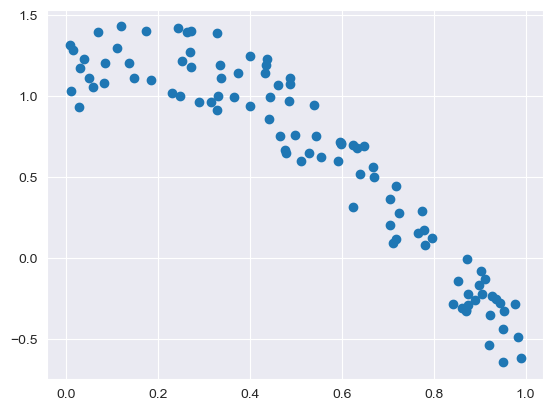

In [15]:
N = 100
x = torch.rand(N, 1)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1)
plt.scatter(x, y)

In [16]:
ones = torch.ones(N, 1)
X = torch.cat([x, ones], dim=1)

In [17]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [18]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)

In [19]:
y_ = x_ * R[0] + R[1]

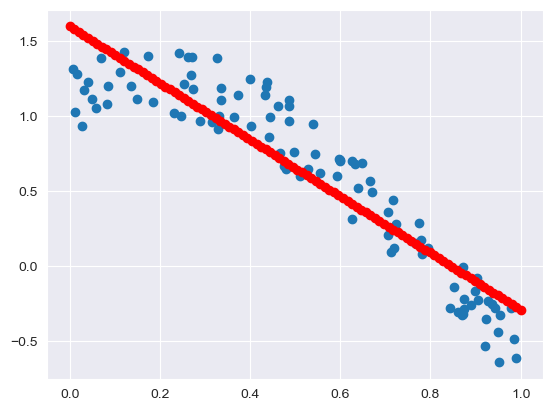

In [20]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

# nonlinear

In [23]:
ones = torch.ones(N, 1)
X = torch.cat([x**2, x, ones], dim=1)

In [24]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [25]:
y_ = x_**2 * R[0] + x_ * R[1] + R[2]

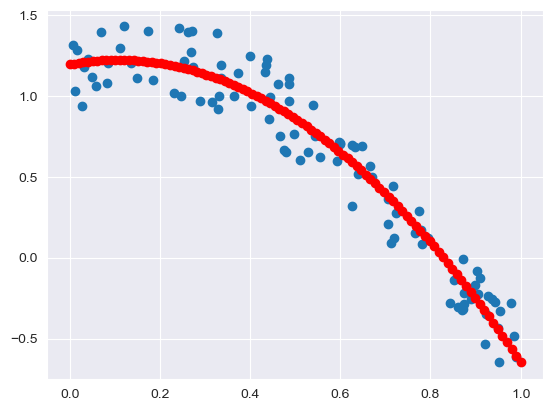

In [26]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

In [27]:
device = 'cpu'

N = 100000000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

t1 = time.time()
degree = 1
ones = torch.ones(N, 1).to(device)
X = torch.cat([x, ones], dim=1)
for i in range(2, degree + 1):
    X = torch.cat([x**i, X], dim=1)
R = torch.inverse(X.T @ X) @ X.T @ y
print(time.time() - t1)

0.8696410655975342


# MLP

In [36]:
from torch import nn

In [37]:
# [1] 32 16 [1]
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return self.fc3(x)

In [38]:
(1*32+32) + (32*16+16) + (16*1+1)

609

In [39]:
model = Regressor()

In [40]:
gen = iter(model.parameters())

In [41]:
next(gen).shape

torch.Size([32, 1])

In [42]:
N = 1000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

In [43]:
device = 'cuda' 

model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(x.to(device))
    loss = criterion(y_, y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 0.9893922209739685
100: 0.3203916847705841
200: 0.25539344549179077
300: 0.1394120156764984
400: 0.06986819952726364
500: 0.0589941143989563
600: 0.05632738023996353
700: 0.054310016334056854
800: 0.052587319165468216
900: 0.05106886848807335
1000: 0.04969418793916702
1100: 0.048423510044813156
1200: 0.04723013564944267
1300: 0.04609591141343117
1400: 0.04500843957066536
1500: 0.04395933076739311
1600: 0.042943075299263
1700: 0.041956279426813126
1800: 0.04099707305431366
1900: 0.04006476700305939
2000: 0.03915950655937195
2100: 0.03828204795718193
2200: 0.03743358701467514
2300: 0.036615557968616486
2400: 0.035829491913318634
2500: 0.03507692739367485
2600: 0.034359272569417953
2700: 0.033677756786346436
2800: 0.03303331509232521
2900: 0.032426584511995316
3000: 0.03185785189270973
3100: 0.03132703900337219
3200: 0.030833713710308075
3300: 0.030377097427845
3400: 0.029956115409731865
3500: 0.029569393023848534
3600: 0.029215363785624504
3700: 0.02889224700629711
3800: 0.02859815023

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

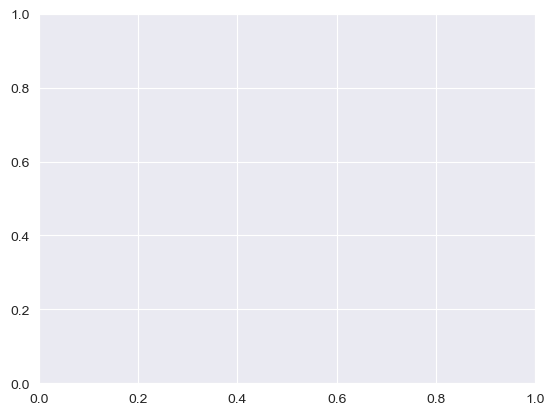

In [44]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)
model.eval()
with torch.no_grad():
    y_ = model(x_.to(device))
plt.scatter(x, y)
plt.scatter(x_, y_.cpu(), color='r')
plt.show()

# Classification

In [38]:
N

1000

In [39]:
X.shape

torch.Size([100000000, 2])

In [40]:
Y = torch.cat([torch.zeros(N), torch.ones(N), torch.ones(N) * 2]).long()

In [41]:
Y

tensor([0, 0, 0,  ..., 2, 2, 2])

In [42]:
X.shape[1]

2

In [43]:
len(Y.unique())

3

In [44]:
# [2] 32 16 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [49]:
model = Classifier()

In [50]:
device = 'cpu' #if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(X.to(device))
    loss = criterion(y_, Y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

ValueError: Expected input batch_size (100000000) to match target batch_size (3000).

In [48]:
model.eval()
with torch.no_grad():
    y_ = model(X.to(device))
acc = torch.sum(Y == y_.argmax(dim=1).cpu()) / len(Y)
print(acc.item())

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.92 GiB. GPU 

In [45]:
from sklearn.datasets import load_iris
import numpy as np
df = load_iris(as_frame=True)

In [46]:
itrain = np.r_[0:25, 50:75, 100:125]
itest = np.r_[25:50, 75:100, 125:150]
xtrain = df['data'].iloc[itrain].values
xtest = df['data'].iloc[itest].values
ytrain = df['target'].iloc[itrain].values
ytest = df['target'].iloc[itest].values

In [47]:
xtrain.shape

(75, 4)

In [48]:
len(np.unique(ytrain))

3

In [49]:
# [4] 128 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 3)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=1)

In [50]:
xtrain_ = torch.tensor(xtrain, dtype=torch.float32)

In [51]:
xtest_ = torch.tensor(xtest, dtype=torch.float32)

In [52]:
ytrain_ = torch.tensor(ytrain, dtype=torch.long)

In [53]:
ytest_ = torch.tensor(ytest, dtype=torch.long)

In [ ]:
model = Classifier()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain_.to(device))
    loss = criterion(y_, ytrain_.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

In [ ]:
model.eval()
with torch.no_grad():
    y_ = model(xtest_.to(device))
acc = torch.sum(ytest_ == y_.argmax(dim=1).cpu()) / len(y_)
print(acc.item())

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model.state_dict()

In [ ]:
df['data'].columns

In [ ]:
df['data'].max()

# Titanic

In [51]:
import seaborn as sns

In [52]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [53]:
df.nunique()

survived         2
pclass           3
sex              2
age             88
sibsp            7
parch            7
fare           248
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [54]:
df = df.drop(columns=['class', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'])

In [55]:
import pandas as pd

In [56]:
df = pd.get_dummies(df, dtype=float)

In [57]:
df

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [58]:
df = df.drop(columns=['sex_female'])

In [59]:
df

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [60]:
df = df.dropna()

In [61]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [62]:
X

,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,0.0,0.0,1.0
886,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [63]:
Y

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: survived, Length: 714, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

In [66]:
xtrain = torch.tensor(xtrain.values, dtype=torch.float32)
xtest = torch.tensor(xtest.values, dtype=torch.float32)
ytrain = torch.tensor(ytrain.values, dtype=torch.float32)
ytest = torch.tensor(ytest.values, dtype=torch.float32)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [67]:
xtrain.shape

torch.Size([571, 12])

In [68]:
ytrain.unique()

tensor([0., 1.])

In [69]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [70]:
model = Classifier()

In [71]:
ytrain.shape

torch.Size([571, 1])

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain.to(device))
    loss = criterion(y_, ytrain.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 2.7099344730377197
100: 0.4082913100719452
200: 0.3590969145298004
300: 0.34265217185020447
400: 0.3176117539405823
500: 0.3047686219215393
600: 0.29076170921325684
700: 0.2791198790073395
800: 0.2648063004016876
900: 0.25029540061950684
1000: 0.2435622364282608
1100: 0.23457829654216766
1200: 0.23070818185806274
1300: 0.22566621005535126
1400: 0.3231053054332733
1500: 0.22190062701702118
1600: 0.21756039559841156
1700: 0.21359580755233765
1800: 0.208483025431633
1900: 0.20993949472904205
2000: 0.20026783645153046
2100: 0.1979113072156906
2200: 0.19872145354747772
2300: 0.19291459023952484
2400: 0.19141964614391327
2500: 0.18974728882312775
2600: 0.1877841204404831
2700: 0.1852702647447586
2800: 0.18907280266284943
2900: 0.18665796518325806
3000: 0.18318523466587067
3100: 0.1794455200433731
3200: 1.4631565809249878
3300: 0.18051302433013916
3400: 0.17579612135887146
3500: 0.17262588441371918
3600: 0.17034253478050232
3700: 0.1686151921749115
3800: 0.1669989973306656
3900: 0.16519013

In [73]:
model.eval()
with torch.no_grad():
    y_ = model(xtest.to(device))
acc = torch.sum(ytest == y_.round().cpu()) / len(y_)
print(acc.item())

0.7622377872467041
